In [54]:
import torch
import torchaudio as ta
from torch.utils.data import Dataset
import torchvision as tv
import pandas as pd
import os
import numpy as np
from itertools import compress
import librosa
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchaudio.transforms import Spectrogram
import torchvision.transforms as transforms
import random
import torchaudio.functional as AF

In [46]:
# Method to move tensors to chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
dir = os.getcwd() #"Z:\\Audio_data\\Dawn_chorus_raw_data"
dir_files = os.listdir(dir)
soundscape_file = os.path.join(dir, list(compress(dir_files, [file.endswith("_single.parquet") for file in dir_files]))[0])
sound_df = pd.read_parquet(soundscape_file)

In [5]:
recording_dir = ("Z:\\Audio_data\\Dawn_chorus_conversion_flac")
dir_files = os.listdir(recording_dir)
dir_files = list(compress(dir_files, [file.endswith(".flac") for file in dir_files]))

In [6]:
dir_files = [int(f.split('_')[0]) for f in dir_files]

In [7]:
recording_df = pd.DataFrame({"id":dir_files})

In [8]:
sound_df.merge(recording_df).id.values

array([19068740, 19096975, 19115260, ..., 27438973, 27905708, 27905712],
      shape=(43742,))

In [121]:
class SpectroDataset(Dataset):
    def __init__(self, 
                recording_path: List[str], 
                label_path: List[str],
                #  transform: None | Callable,
                sampling_rate: int = 44100, #Hz
                loudness: int = 10,
                device = 'cpu',
                **kwargs):
        self.l_path = label_path
        self.r_path = recording_path

        dir_files = os.listdir(label_path)
        soundscape_file = os.path.join(self.l_path, list(compress(dir_files, [file.endswith("_single.parquet") for file in dir_files]))[0])
        sound_df = pd.read_parquet(soundscape_file)

        dir_files = os.listdir(recording_path)
        dir_files = list(compress(dir_files, [file.endswith(".flac") for file in dir_files]))

        dir_files = [int(f.split('_')[0]) for f in dir_files]

        recording_df = pd.DataFrame({"id":dir_files})

        self.file_df = sound_df.merge(recording_df)
        
        self.fileNames = self.file_df.id.values
        self.fileLabels = self.file_df.label.values
        # self.transforms = transform
        self.sampling_rate = sampling_rate
        self.loudness = loudness
        self.device = device
    
    def __len__(self):
        return len(self.fileNames)
    
    def __getitem__(self, idx):
        #x = torch.zeros(10*self.sr)
        print("Getting", os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))
        # Uses native sampling rate of the file
        # Normalize arg does bit depth normalization
        # Move to device specified
        wave, sr = ta.load(uri=os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))#, normalize=True)
        
        # Move to specified device, e.g. GPU
        wave = wave.to(torch.float32)
        
        # Resample to the sampling rate given by the args 
        if sr != self.sampling_rate:
            print(f"Initial sampling rate is {sr}, resampling to {self.sampling_rate}")
            wave = ta.functional.resample(wave, sr, self.sampling_rate)

        # LUFS normalization to a given loudness
        wave_loudness = AF.loudness(wave, self.sampling_rate)
        gain = self.loudness - wave_loudness
        multiplier = 10 ** (gain/20)
        wave = wave * multiplier
        
        # for testing sample only seconds 10 to 20
        llimit = int(self.sampling_rate * 10)
 
        wave = wave[:, int(llimit):int(llimit*2)]

        # Squeeze to go from 1,x to x shape tensor
        wave = to_device(wave.squeeze(), self.device)
        return wave, sr, int(self.fileLabels[idx])

In [122]:
ds = SpectroDataset("Z:\\Audio_data\\Dawn_chorus_conversion_flac", os.getcwd(), device = 'cuda')

In [123]:
def splitDataset(dataset, test_split_size = 0.2, val_split_size = 0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    test_split = int(np.floor(test_split_size * dataset_size))
    val_split = int(np.floor(val_split_size * dataset_size))

    val_indices, test_indices, train_indices = indices[:val_split], indices[val_split: (val_split+test_split)], indices[(val_split+test_split):]

    return train_indices, test_indices, val_indices 


In [124]:
train_indices, test_indices, val_indices  = splitDataset(ds)

In [125]:
samples = 0

In [126]:
wave, sr, label = ds.__getitem__(samples)

Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19068740_audio.flac


In [127]:
class SpectroDataLoader():
    """
    """

    def __init__(self, datas, batch_size, samples, device='cpu'):
        self.waves = []
        self.lbs = []
        self.sr = []
        self.device = device

        # Append to each array the values returned in the dataset class (wave, sampling_rate, label)
        for idx in samples:
            print(idx)
            elem=datas[idx]
            self.waves.append(elem[0])
            self.sr.append(elem[1])
            self.lbs.append(elem[-1])

        # Shuffle all waves
        self.datas = list(zip(self.waves, self.lbs))
        random.shuffle(self.datas)

        # Attributes for batching
        self.batch_size = batch_size
        self.image_batches = []
        self.label_batches = []

        while (len(self.datas) / self.batch_size > 0) | (len(self.datas) % self.batch_size != 0):

            # first n entries of shuffled vector are batch
            batch = self.datas[:self.batch_size]

            wvs = []
            las = []

            # Need to separate images and labels into two tensors
            for wv, la in batch:
                wvs.append(wv)
                las.append(la)
            del self.datas[:self.batch_size]

            self.image_batches.append(wvs)
            self.label_batches.append(las)

    def __iter__(self):
        bat = list(zip(self.image_batches, self.label_batches))
        random.shuffle(bat)

        # return a random batch
        for image_batch, label_batch in bat:
            yield to_device([torch.stack(image_batch), torch.Tensor(label_batch)], self.device)


In [128]:
train_dataloader = SpectroDataLoader(ds, 256, samples= train_indices[:100], device = "cuda")

13122
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23658096_audio.flac
13123
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853551_audio.flac
13124
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853553_audio.flac
13125
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23862849_audio.flac
13126
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\24104283_audio.flac
13127
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\25408667_audio.flac
13128
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26172099_audio.flac
13129
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26563106_audio.flac
13130
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26747817_audio.flac
13131
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26755651_audio.flac
13132
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26783670_audio.flac
13133
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26822314_audio.flac
13134
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26831857_audio.flac
13135
Gettin

In [130]:
tens, label =next(iter(train_dataloader))

In [142]:
tens.shape

torch.Size([100, 441000])

In [133]:
n_fft = 4096
scale = 1 

In [136]:
q = to_device(Spectrogram(n_fft=n_fft, hop_length=n_fft//4, power=2), "cuda")

In [143]:
spec = q(tens[0])
# spec = torch.where(spec < 1, 1, spec)
# spec = torch.unsqueeze(torch.log10(spec) / scale, 1)

In [144]:
spec.shape

torch.Size([2049, 431])

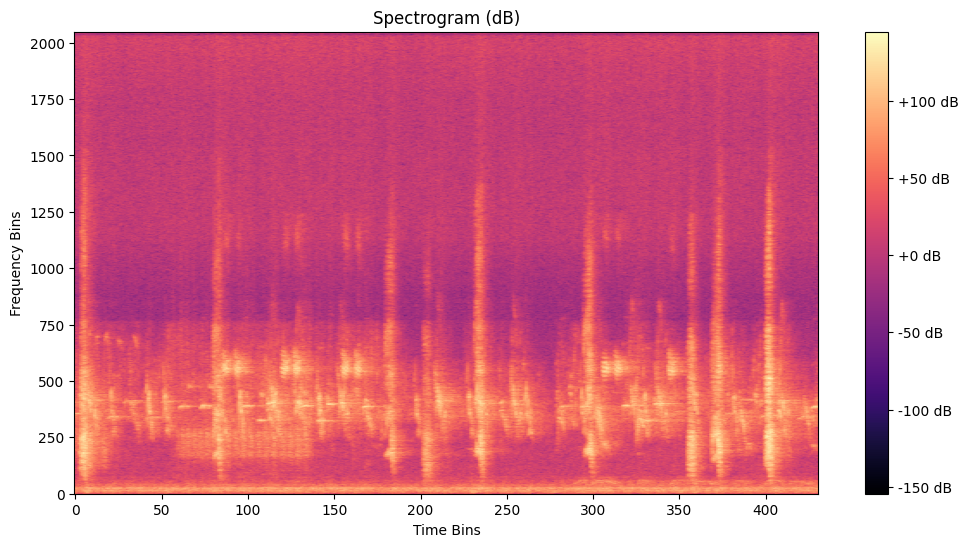

In [145]:
import torch
import matplotlib.pyplot as plt

# 1. Convert to Decibels (essential for visibility)
# Use 10 * log10 for power spectrograms, 20 * log10 for amplitude
spec_db = to_device(20 * torch.log10(spec.squeeze() + 1e-10), "cpu")

# 2. Plotting
plt.figure(figsize=(12, 6))
plt.imshow(
    spec_db.numpy(), 
    origin='lower',    # Puts low frequencies at the bottom
    aspect='auto',     # Stretches the image to fill the plot area
    cmap='magma'       # 'magma' or 'viridis' are great for audio
)
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
plt.ylabel("Frequency Bins")
plt.xlabel("Time Bins")
plt.show()

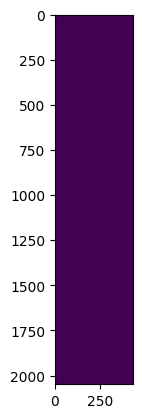

In [224]:
plt.imshow(spec.permute(1,2,0))

In [ ]:
class AudioToLogSpectrogram(torch.nn.Module):
    def __init__(
        self,
        n_fft=4096,
        scale=1
    ):
        super().__init__()
        ta.transforms.resample()
        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=n_fft//4, power=2)
        self.scale = scale
        im = transforms.Resize((224, 224))(im)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Convert to power spectrogram
        spec = self.spec(waveform)
        spec = torch.where(spec < 1, 1, spec)
        return torch.unsqueeze(torch.log10(spec) / self.scale, 1)

In [100]:
# Parameters for the ElasticNet penalty
l1_lambda = 0.002
l2_lambda = 0.0015


nnw = tv.models.resnet18()
to_device(nnw, device)


loss = nn.CrossEntropyLoss()

# fused doesn't work without cuda
if device == 'cuda':
    optimizer = optim.Adam(nnw.parameters(), lr=0.0001, fused=True)
else:
    optimizer = optim.Adam(nnw.parameters(), lr=0.0001)

# Train the network
for epoch in range(40):  # loop over the dataset multiple times
    nnw.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = nnw(inputs)

        labels_long = labels.type(torch.LongTensor)
        labels_long = to_device(labels_long.long(), device)

        los = loss(outputs, labels_long)

        # L1 Regularization
        l1_penalty = sum(p.abs().sum() for p in nnw.parameters())

        # L2 Regularization
        l2_penalty = sum(p.pow(2.0).sum() for p in nnw.parameters())

        # Elastic Net Penalty
        elastic_penalty = l1_lambda * l1_penalty + l2_lambda * l2_penalty

        los += elastic_penalty

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute gradients
        los.backward()

        # Update model parameters
        optimizer.step()

        # print statistics
        running_loss += los.item()
        if i % 16 == 15:  # print every 16 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.6f}')
            running_loss = 0.0
nnw.eval()
print('Finished Training')

441000


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 3, 147000] to have 3 channels, but got 1 channels instead